In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from scipy import sparse
from scipy.sparse import linalg as sla
from tqdm.notebook import tqdm
from usadel import (
    Grad,
    Laplacian1D,
    gen_assemble_fun,
    solve_usadel,
    solve_usadel_self_consistent,
)

In [3]:
plt.style.use("sans_style.mplstyle")

# Setup

In [4]:
Ny = 21
Nx = 201
Nsites = Nx * Ny

x_ax = np.linspace(-100, 100, Nx)
dx = x_ax[1] - x_ax[0]

y_ax = np.linspace(0, 0.2, Ny)
dy = y_ax[1] - y_ax[0]

x, y = np.meshgrid(x_ax, y_ax, indexing="ij")

In [6]:
T_c0 = 1
Delta_00 = T_c0 * 1.7652
h_c0 = Delta_00 / np.sqrt(2)

D = 1**2 * Delta_00
xi_00 = np.sqrt(D / Delta_00)

In [12]:
h_x_2D = np.zeros((Nx, Ny), dtype=float)
h_y_2D = np.zeros((Nx, Ny), dtype=float)

M_s = 2
L_dw = 5
M_x = M_s * np.tanh(x_ax / L_dw)
M_y = M_s * 1 / np.cosh(x_ax / L_dw)

#h_x_2D = np.tile(M_x, (Ny, 1)) * np.exp(-y / xi_00 * 10)
#h_x_2D = np.tile(M_y, (Ny, 1)) * np.exp(-y / xi_00 * 10)

h_x_2D[: Nx // 2, : Ny // 2] = -2
h_x_2D[Nx // 2 :, : Ny // 2] = 2

h_x = h_x_2D.flatten()
h_y = h_y_2D.flatten()

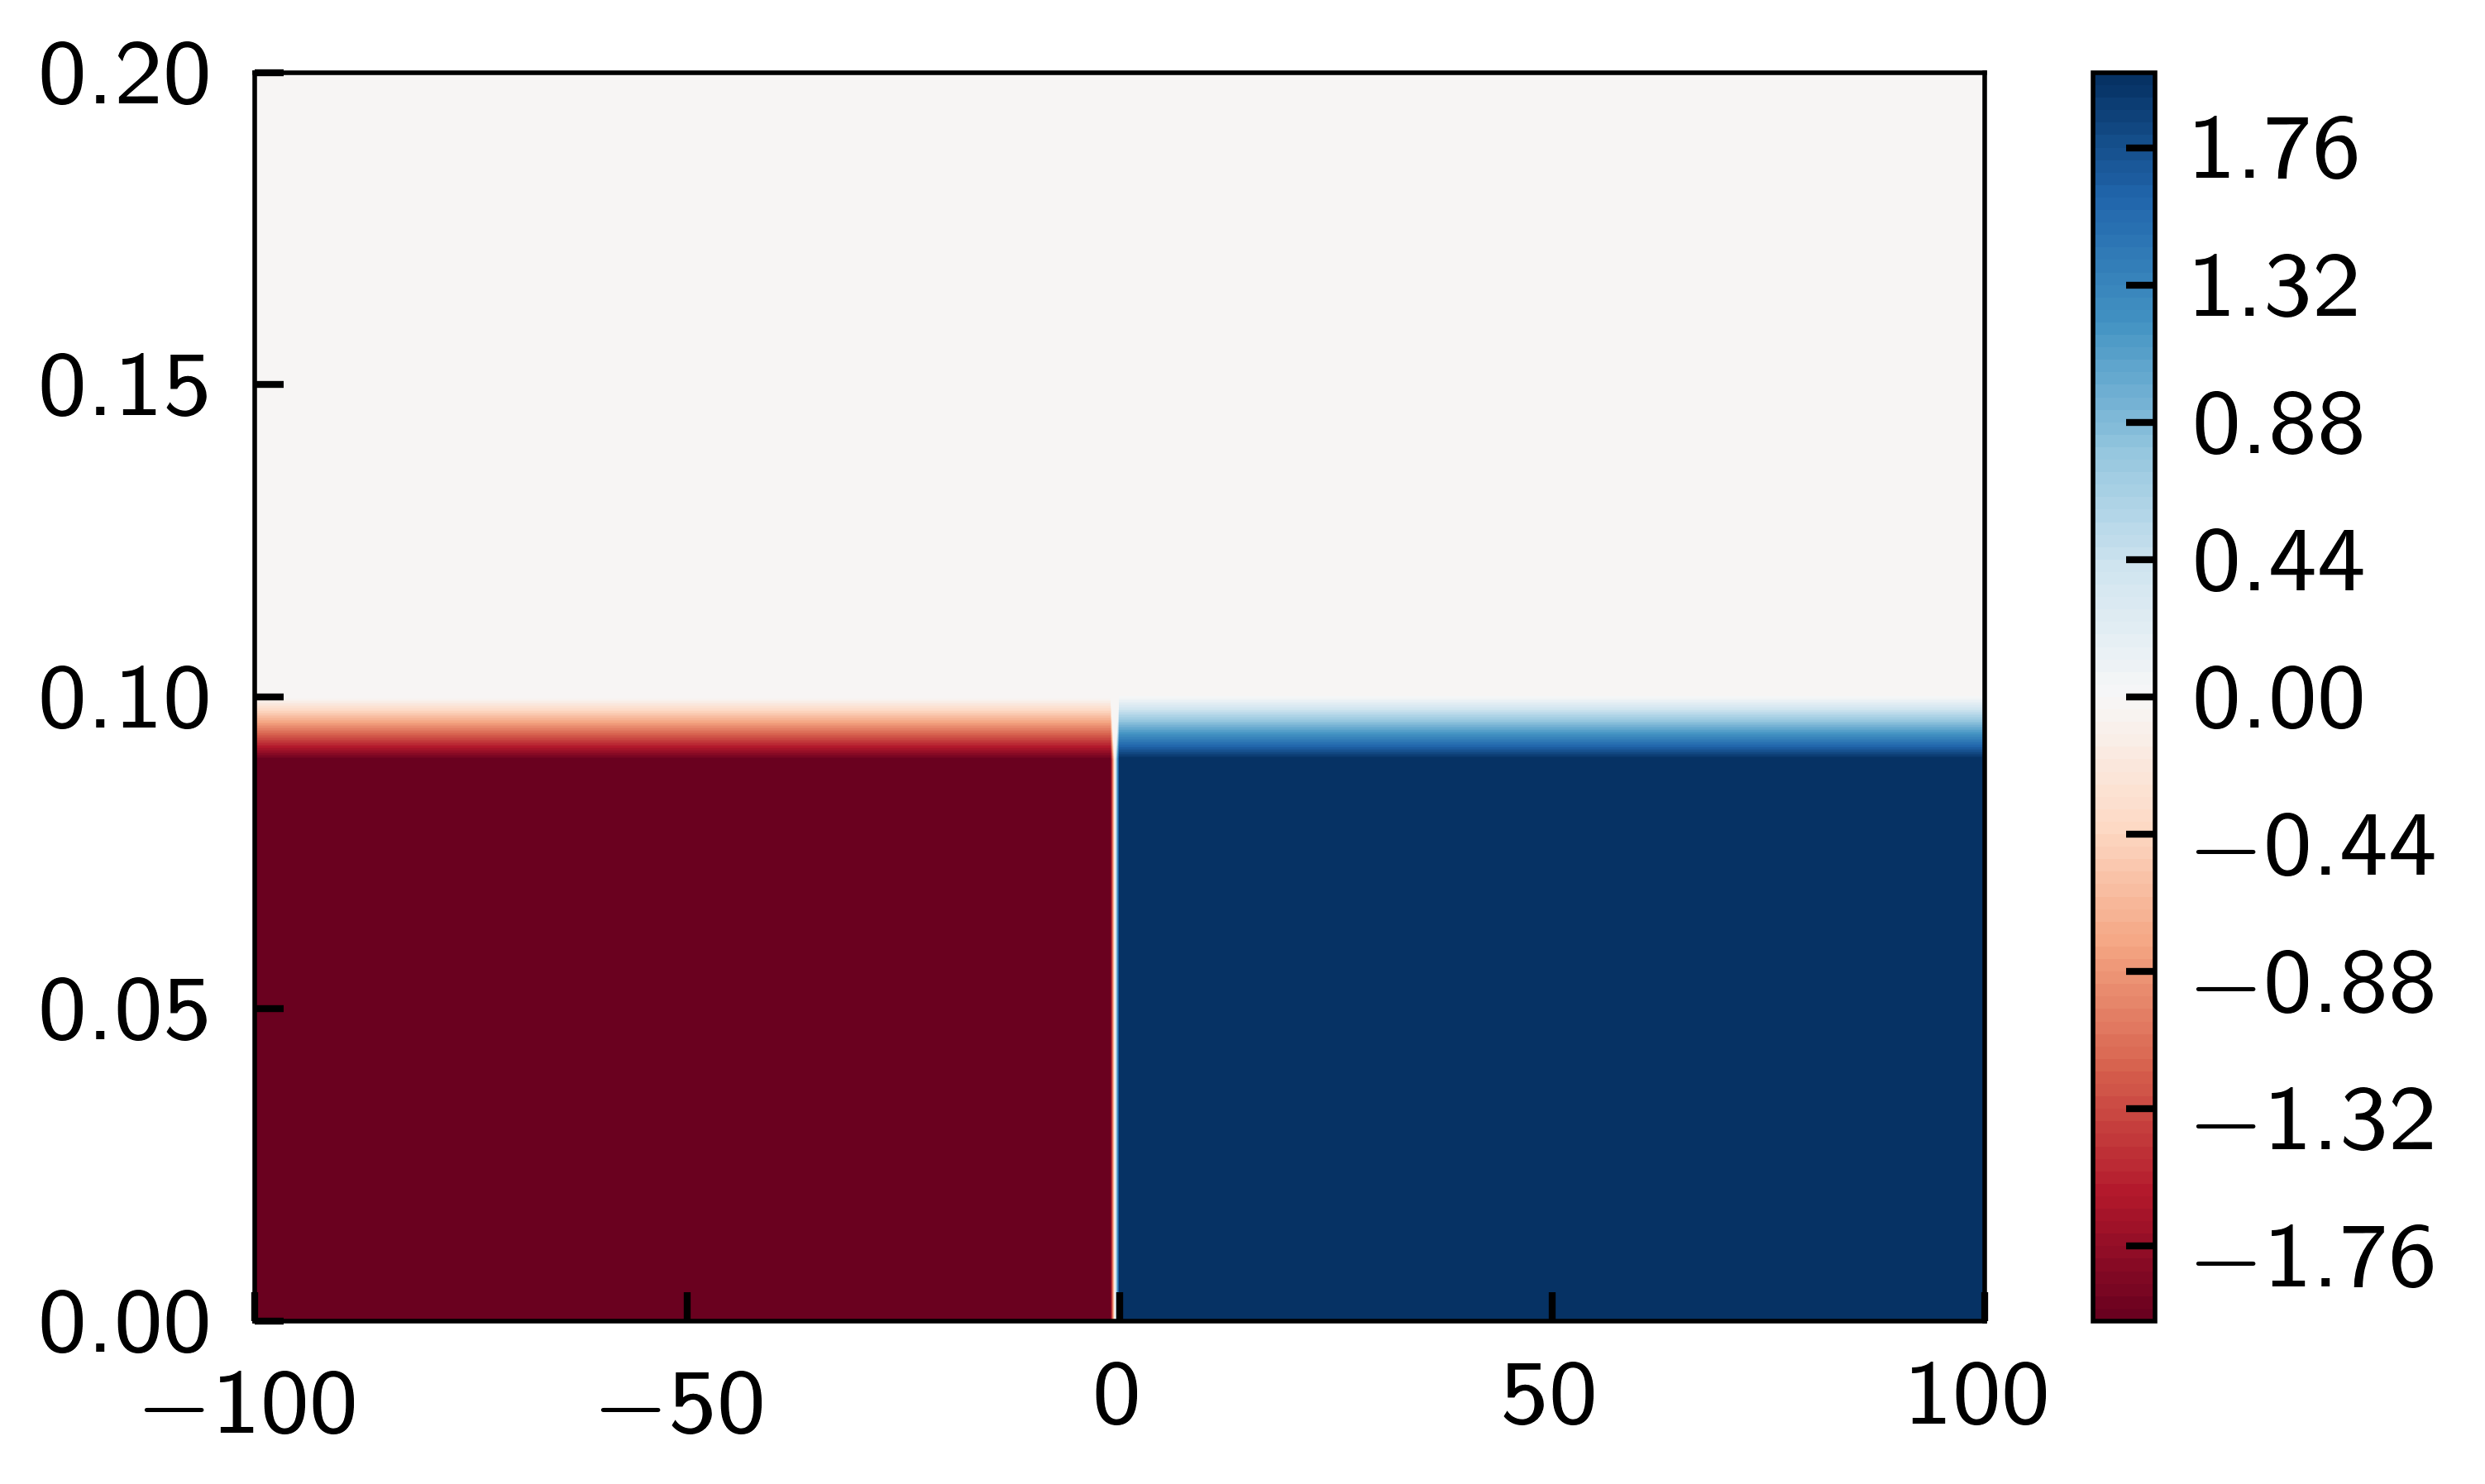

In [17]:
im = plt.contourf(x, y, h_x_2D, cmap='RdBu', levels=101)
plt.colorbar(im)

In [18]:
T_c0 = 1
Delta_00 = T_c0 * 1.7652
h_c0 = Delta_00 / np.sqrt(2)

D = (1 ** 2) * Delta_00
xi_00 = np.sqrt(D / Delta_00)

In [19]:
tau_so_inv = 0.0
tau_sf_inv = 0.0

In [22]:
I_y = sparse.eye(Ny)
I_x = sparse.eye(Nx)
D_x = sparse.kron(Grad(Nx) / (2 * dx), I_y)
D_y = sparse.kron(I_x, Grad(Ny) / (2 * dy))

L_x = Laplacian1D(Nx, "open") / dx ** 2
L_y = Laplacian1D(Ny, "open") / dy ** 2
L = sparse.kron(I_x, L_y) + sparse.kron(L_x, I_y)

assemble_fun = gen_assemble_fun(
    D, L, D_x, tau_so_inv, tau_sf_inv
)  # TODO: Dy missing in free energy

scipy.sparse._base.spmatrix

In [91]:
# fig, ax = plt.subplots()
# ax.hlines([h_c, -h_c], -6, 6, colors="k", linestyles="--", linewidth=1)
# ax.plot(x/xi_00, h_x, '-', label=r"$h_x$")
# ax.plot(x/xi_00, h_y, '-', label=r"$h_y$")
# ax.set_xlabel(r"$x / \xi_{00}$")

## Gap equation solver

In [92]:
T_c0 = 1
T = 0.2

Delta = np.zeros((Nsites), dtype=float) + 1.7652  # * (1 - np.abs(x / Nx))

In [93]:
(theta, M_x, M_y, Delta, omega_ax, f_sn) = solve_usadel_self_consistent(
    assemble_fun,
    h_x,
    h_y,
    Delta,
    T,
    omega_N=70,
    gamma=1,
    tol=1e-3,
    max_iter=200,
    max_iter_delta=50,
)

  1    Max Delta: 1.736    Residual: 6.61e-02    Free energy: -3.26e+07
  2    Max Delta: 1.711    Residual: 7.68e-02    Free energy: -3.26e+07
  3    Max Delta: 1.688    Residual: 9.06e-02    Free energy: -3.26e+07
  4    Max Delta: 1.667    Residual: 1.06e-01    Free energy: -3.26e+07
  5    Max Delta: 1.646    Residual: 1.20e-01    Free energy: -3.26e+07
  6    Max Delta: 1.627    Residual: 1.33e-01    Free energy: -3.27e+07
  7    Max Delta: 1.607    Residual: 1.43e-01    Free energy: -3.27e+07
  8    Max Delta: 1.588    Residual: 1.50e-01    Free energy: -3.27e+07
  9    Max Delta: 1.569    Residual: 1.55e-01    Free energy: -3.27e+07
 10    Max Delta: 1.549    Residual: 1.59e-01    Free energy: -3.27e+07
 11    Max Delta: 1.530    Residual: 1.61e-01    Free energy: -3.27e+07
 12    Max Delta: 1.510    Residual: 1.62e-01    Free energy: -3.27e+07
 13    Max Delta: 1.490    Residual: 1.62e-01    Free energy: -3.27e+07
 14    Max Delta: 1.470    Residual: 1.62e-01    Free energy: -3

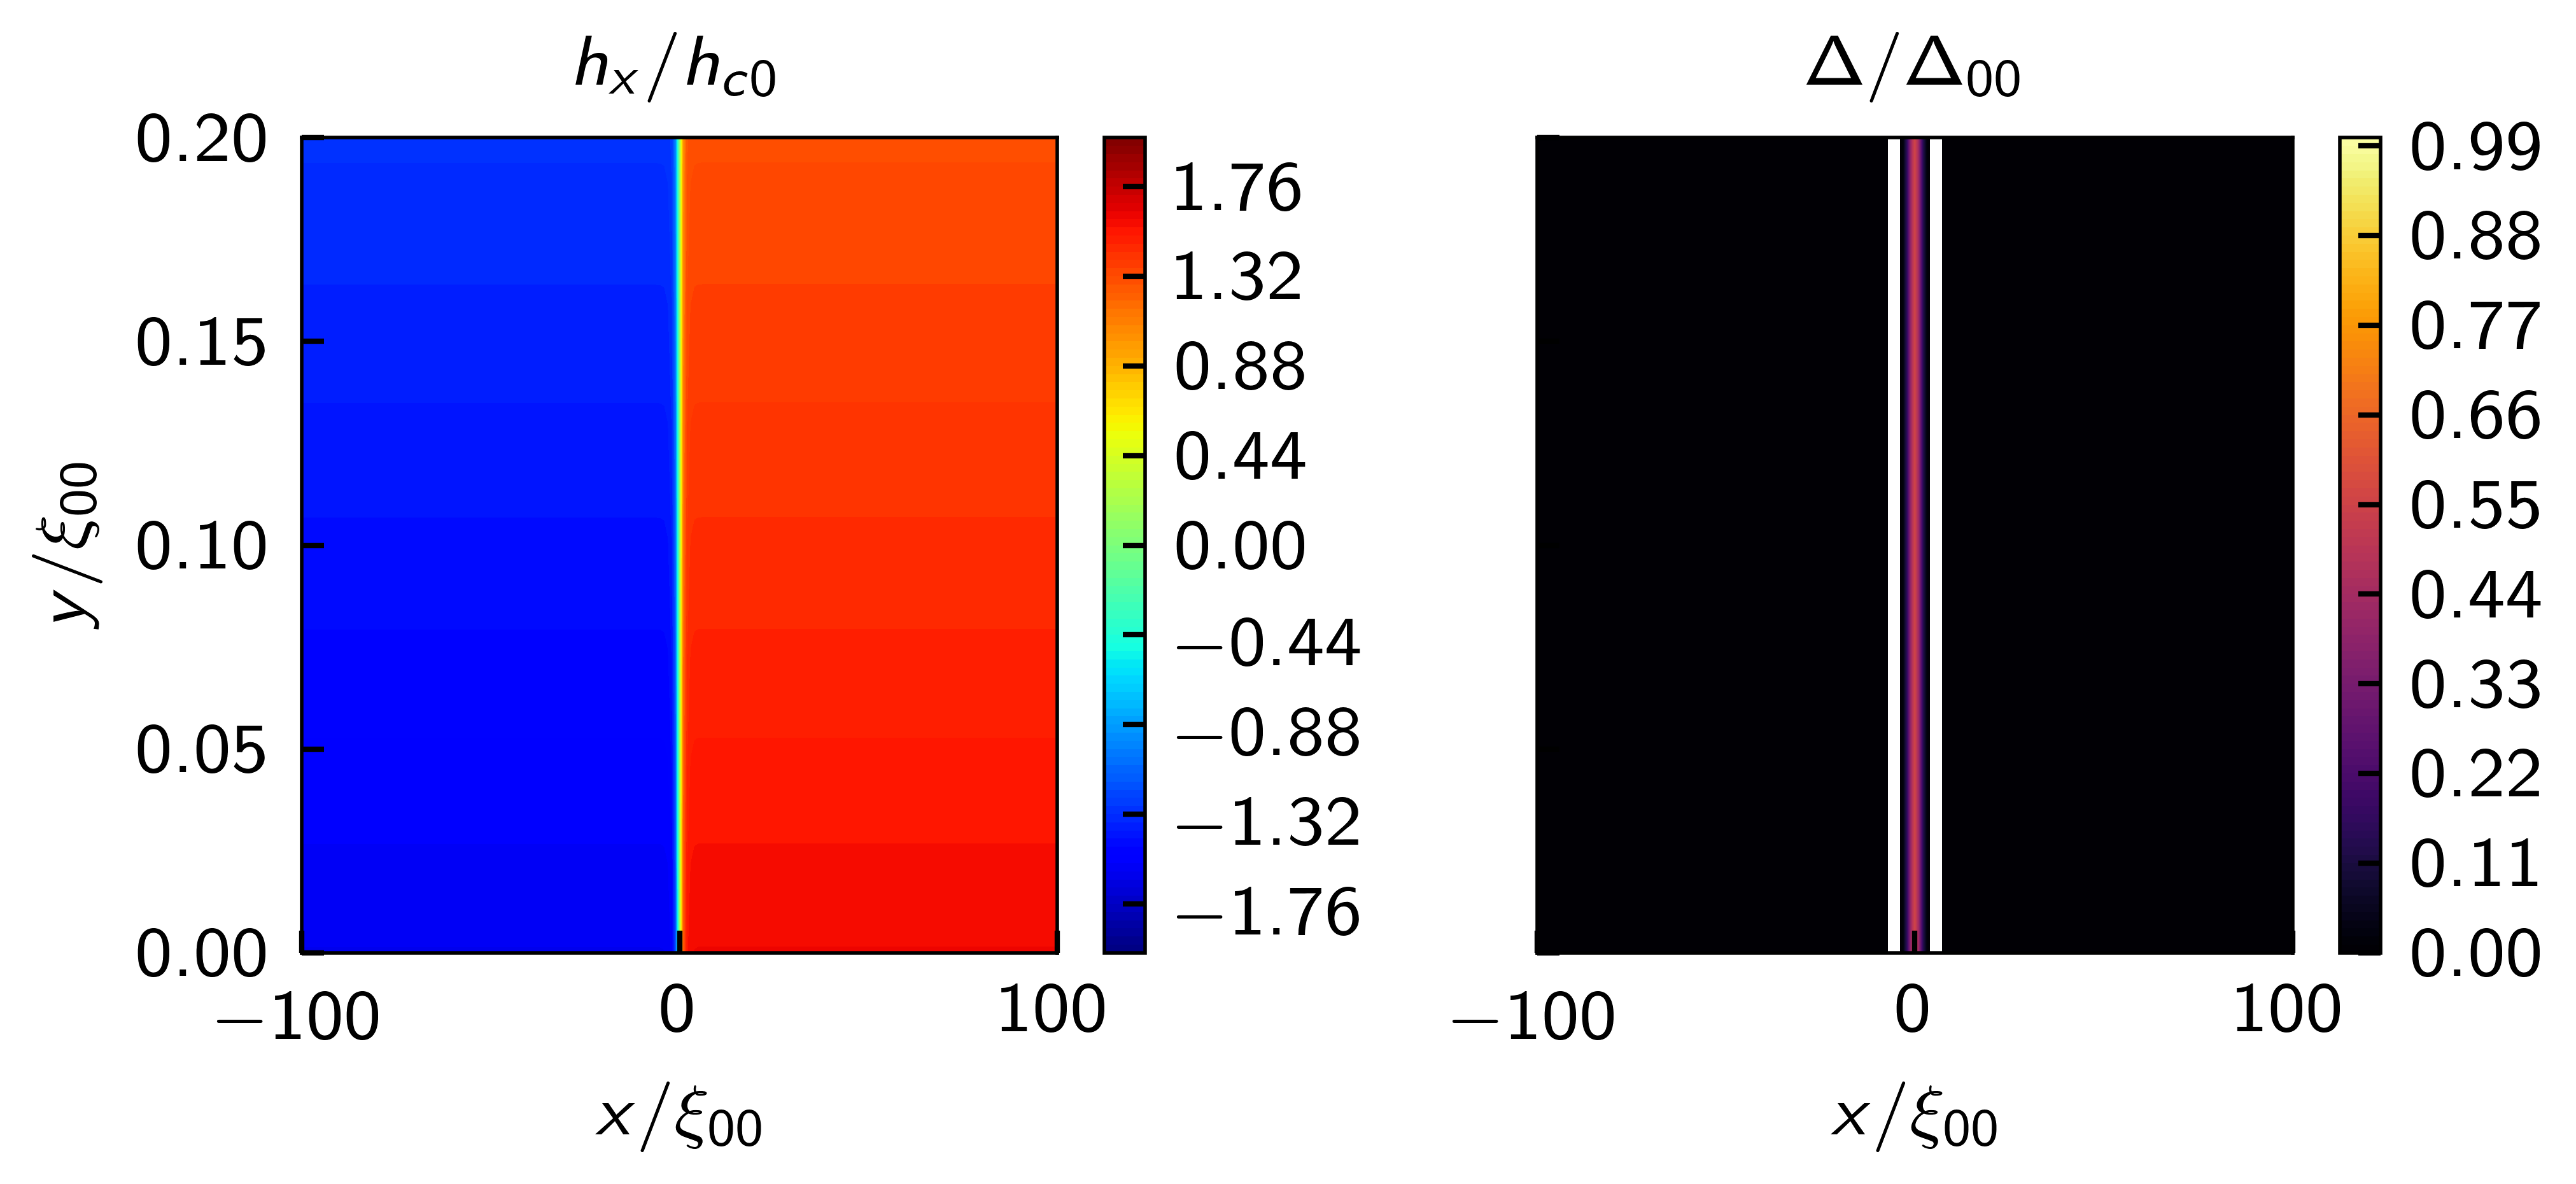

In [94]:
fig, ax = plt.subplots(figsize=(4.2, 2), ncols=2, sharey=True)
im0 = ax[0].contourf(
    x / xi_00,
    y / xi_00,
    h_x.reshape(Nx, Ny) / h_c0,
    cmap="jet",
    levels=np.linspace(-2, 2, 101),
)
ax[0].set_xlabel(r"$x/\xi_{00}$")
ax[0].set_ylabel(r"$y/\xi_{00}$")
cb0 = fig.colorbar(im0, ax=ax[0])
ax[0].set_title(r"$h_x / h_{c0}$")

im1 = ax[1].contourf(
    x / xi_00,
    y / xi_00,
    Delta.reshape(Nx, Ny) / Delta_00,
    cmap="inferno",
    norm=mpl.colors.Normalize(0, 1),
    levels=np.linspace(0, 1, 101),
)
ax[1].set_xlabel(r"$x/\xi_{00}$")
# ax[1].set_ylabel(r"$y/\xi_{00}$")
fig.colorbar(im1, ax=ax[1])
ax[1].set_title(r"$\Delta / \Delta_{00}$")
fig.tight_layout()

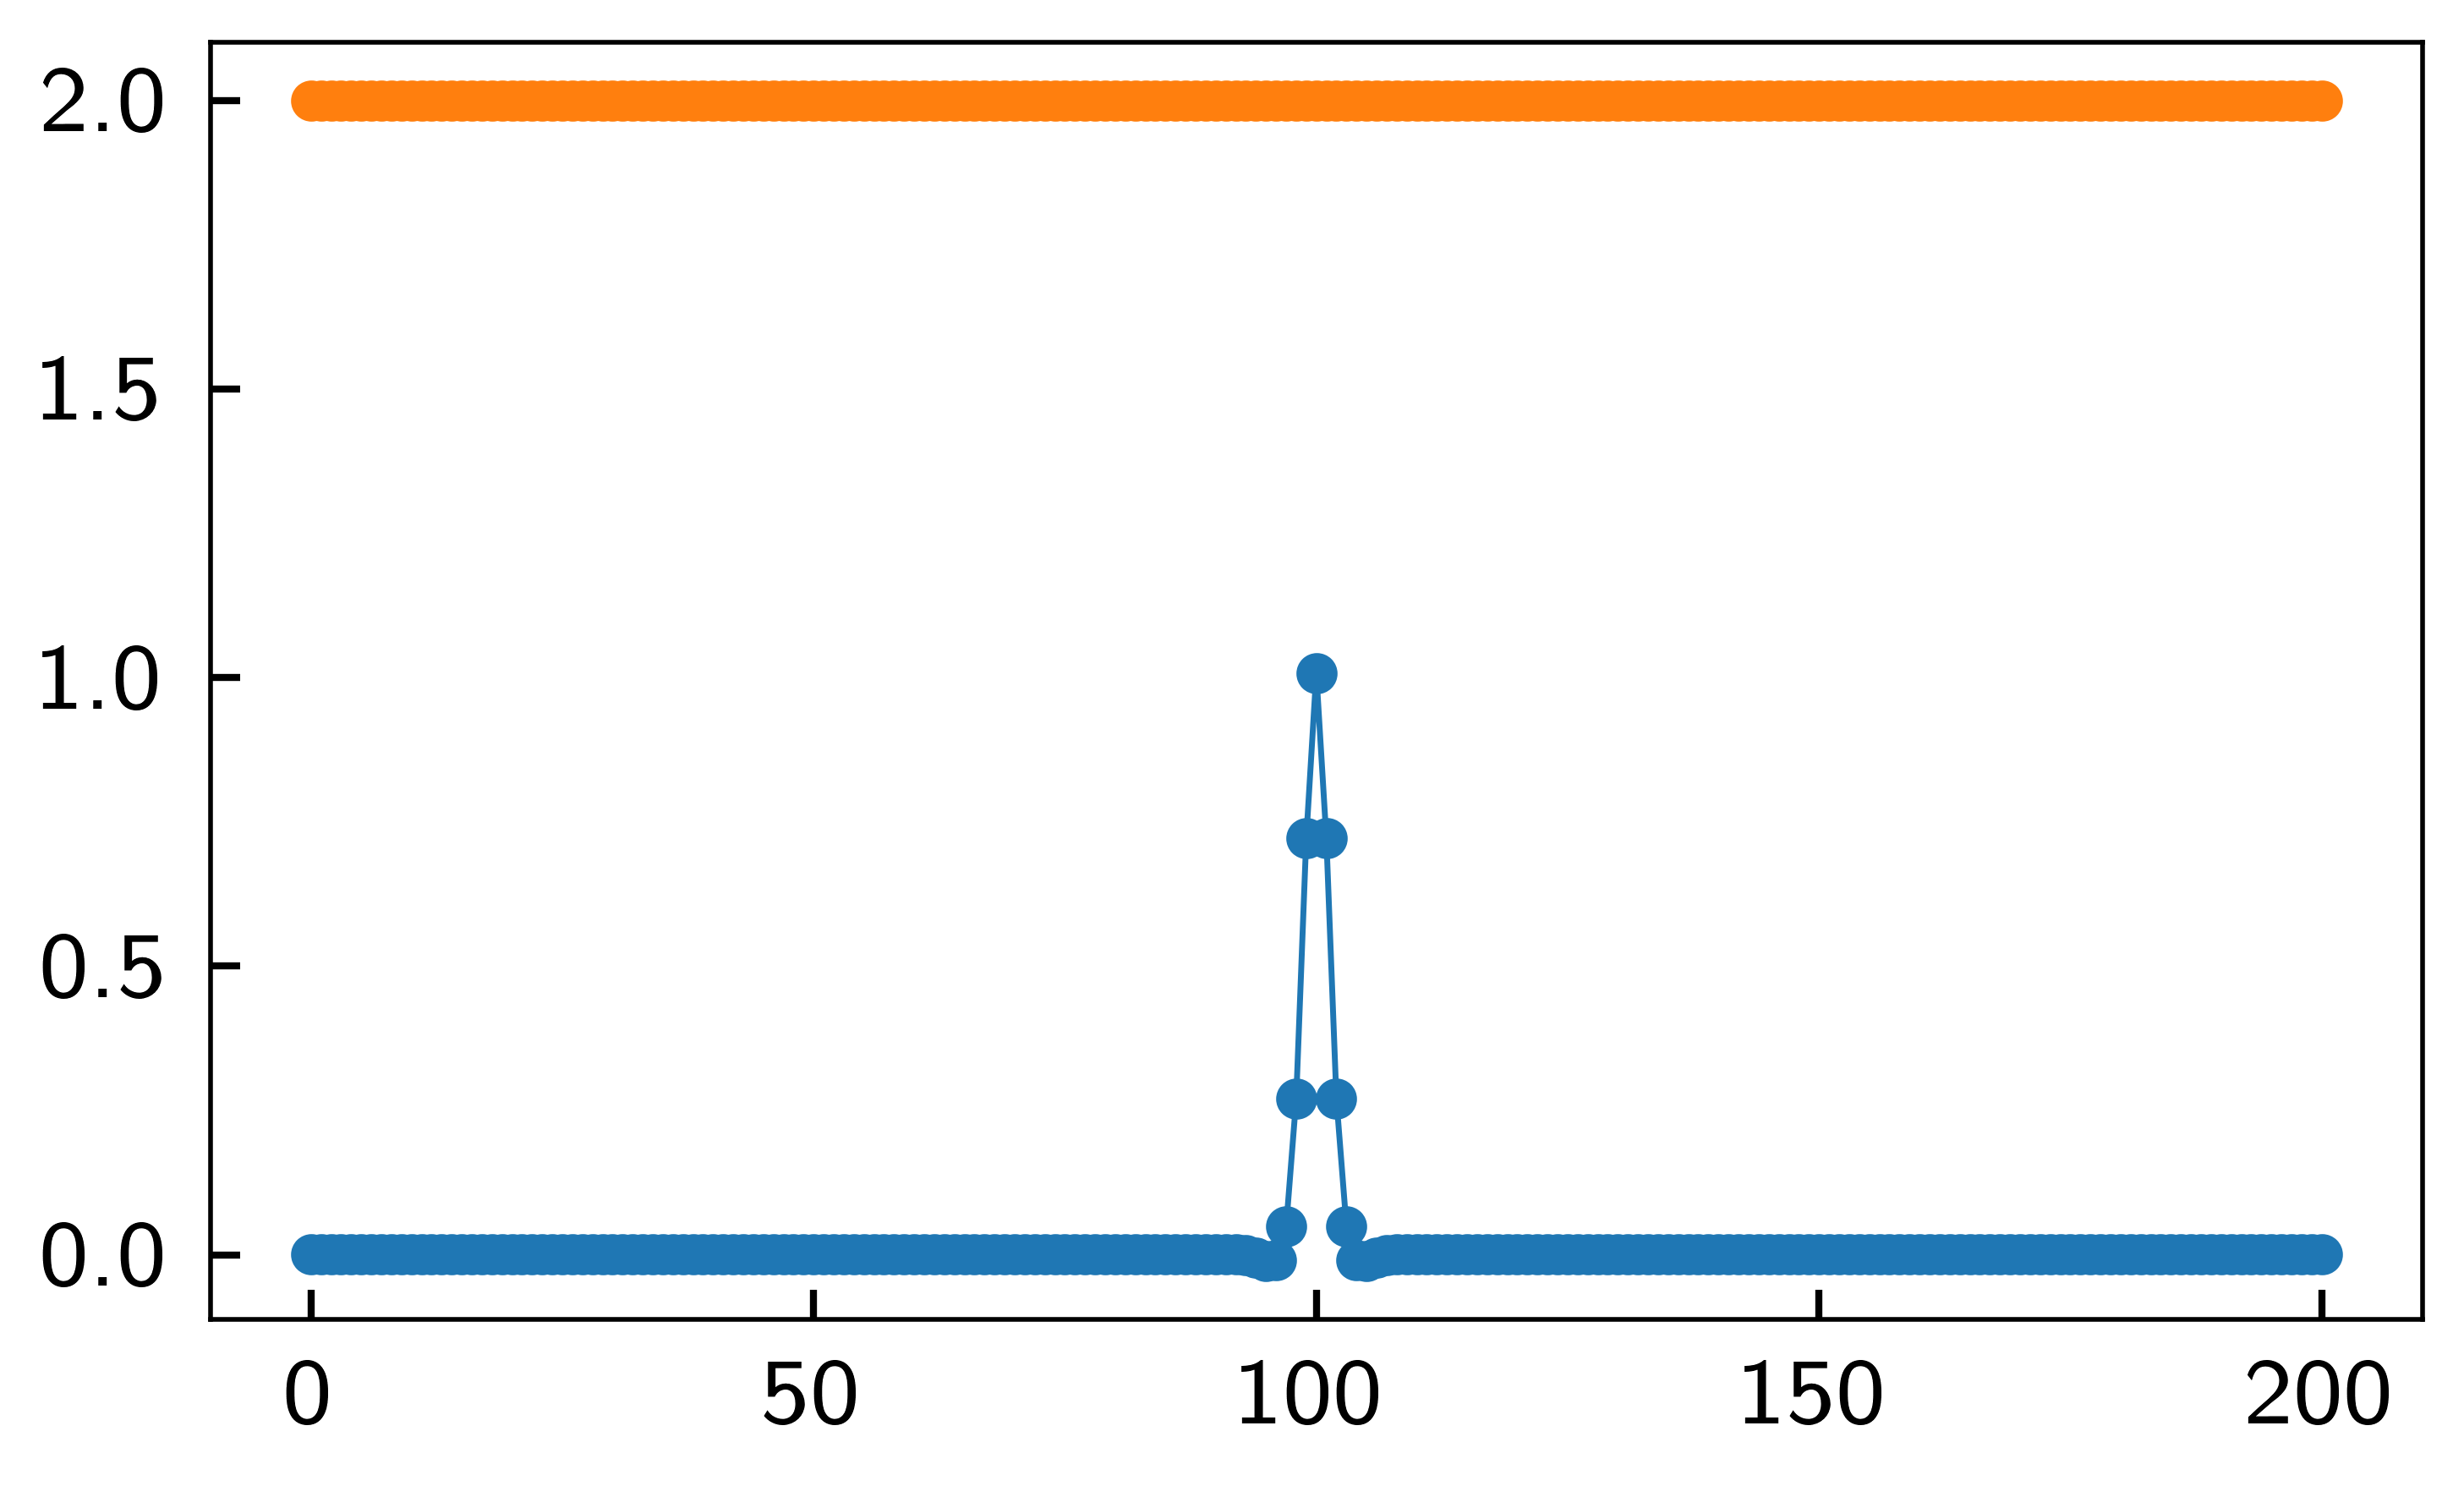

In [99]:
plt.plot(Delta.reshape(Nx, Ny)[:, 0])
plt.plot(h_x.reshape(Nx, Ny)[:, 0])

ValueError: x and y must have same first dimension, but have shapes (101, 21) and (2121,)

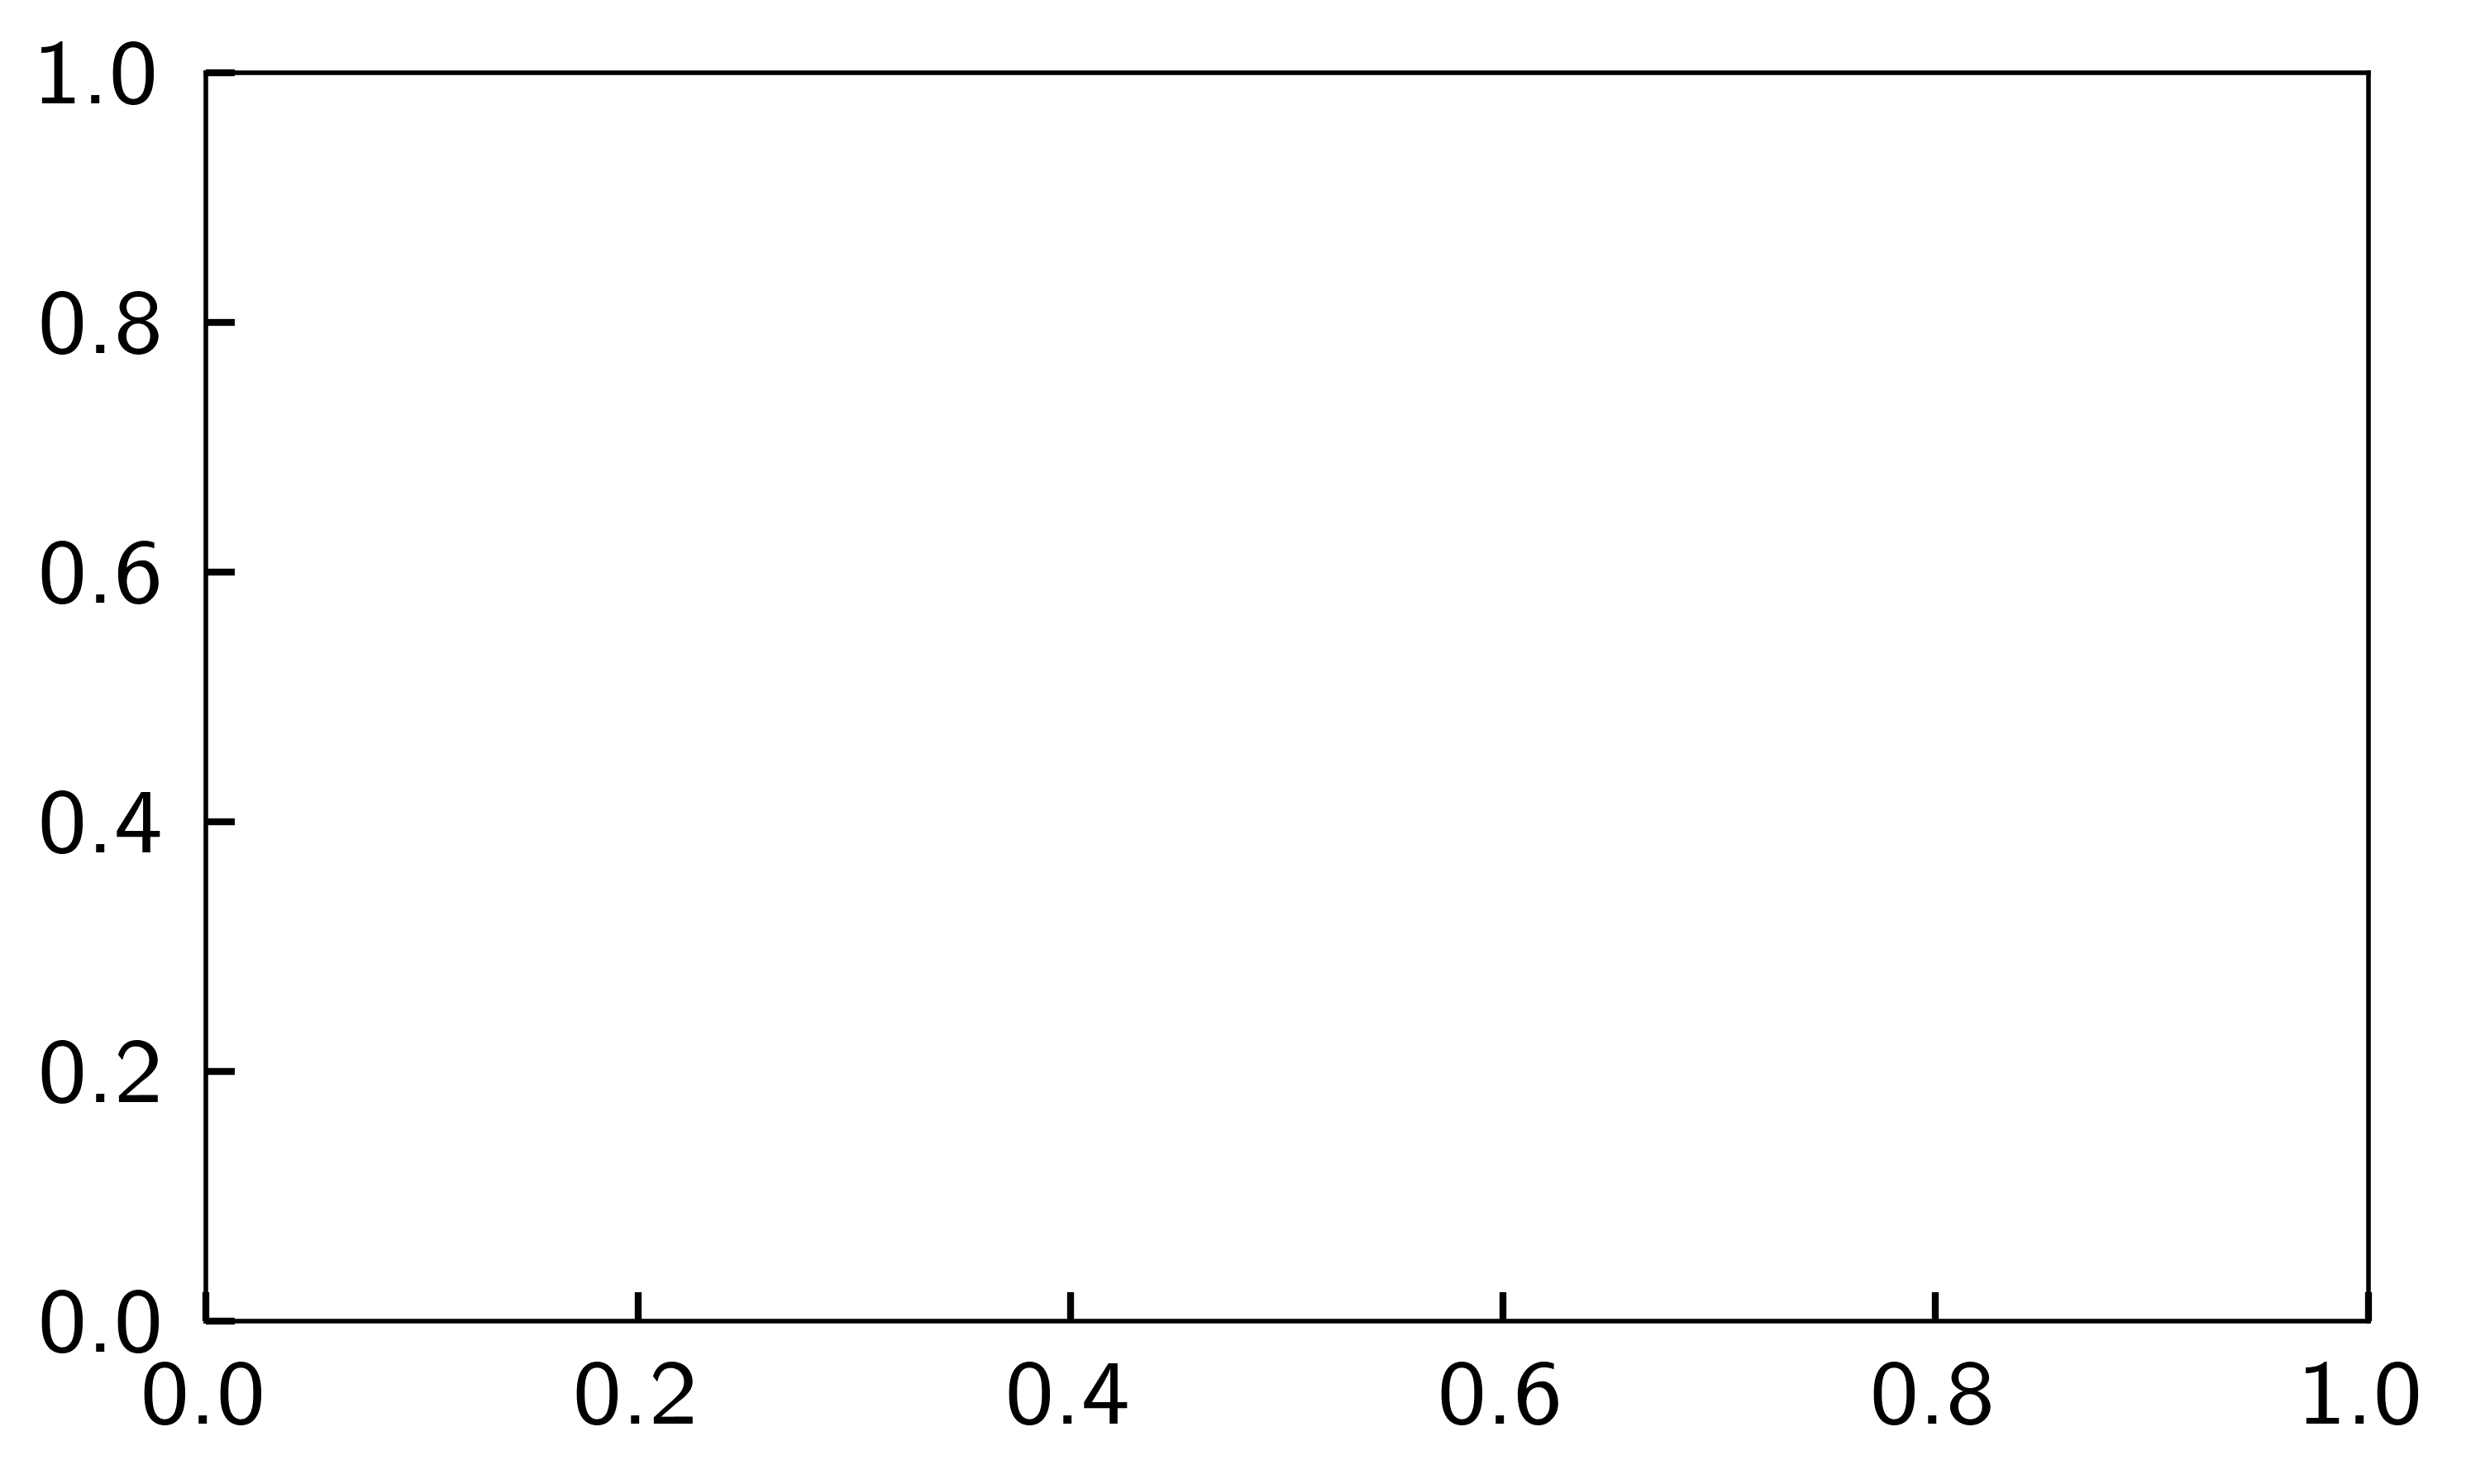

In [15]:
fig, ax = plt.subplots()
ax.plot(x / xi_00, Delta / Delta_00, "-C0", label=r"$\Delta$")
ax.set_ylabel(r"$\Delta / \Delta_{00}$")
ax.vlines([x[cc_idx[0]]] / xi_00, 0, 1, colors="k", linestyles="--", linewidth=0.5)
# ax.vlines([x[cc_idx[1]]/xi_00], 0, 1, colors="-k", linestyles="--", linewidth=1)
ax.plot(
    x / xi_00,
    Delta[50] / Delta_00
    + (np.diff(Delta / Delta_00) / (x[1] - x[0]))[50] * (x - x[50]),
    "C0--",
)

ax.set_ylim(-0.05, 1)
ax.set_xlabel(r"$x/\xi_{00}$")

ax2 = ax.twinx()
ax2.hlines([+h_c], -6, 6, colors="k", linestyles="--", linewidth=0.5)
# ax2.hlines([-h_c], -6, 6, colors="k", linestyles="--", linewidth=1)

ax2.plot(x / xi_00, h_x, "-C1", label=r"$h_x$")
ax2.plot(x / xi_00, h_y, "-C2", label=r"$h_y$")
ax2.set_ylabel(r"$h$")

ax.legend()
ax2.legend()

## Spectrum solver

In [ ]:
omega_N = 101
omega_ax = -1j * np.linspace(-3, 3, omega_N)

theta = np.ones((omega_N, Nsites), dtype=complex)
M_x = np.zeros((omega_N, Nsites), dtype=complex)
M_y = np.zeros((omega_N, Nsites), dtype=complex)

In [ ]:
for omega_idx in range(omega_N):
    solve_usadel(
        assemble_fun[:-1],
        theta,
        M_x,
        M_y,
        h_x,
        h_y,
        Delta,
        omega_ax,
        omega_idx,
        gamma=0.50,
        tol=1e-6,
        max_iter=200,
        print_exit_status=False,
    )

In [ ]:
h_x_2D = h_x.reshape((Ny, Nx))
h_y_2D = h_y.reshape((Ny, Nx))
Delta_2D = Delta.reshape((Ny, Nx))
M_x_2D = M_x.reshape((omega_N, Ny, Nx))
M_y_2D = M_y.reshape((omega_N, Ny, Nx))
theta_2D = theta.reshape((omega_N, Ny, Nx))

M_0_2D = np.sqrt(1 + M_x_2D ** 2 + M_y_2D ** 2)

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(6, 2), sharey=True)

ax[0].plot(
    np.real((M_0_2D * np.cos(theta_2D))[:, 0, 0]), omega_ax.imag,
)
ax[1].plot(
    np.real((M_0_2D * np.cos(theta_2D))[:, 0, 20]), omega_ax.imag,
)
ax[2].plot(
    np.real((M_0_2D * np.cos(theta_2D))[:, 0, 40]), omega_ax.imag,
)
ax[3].plot(
    np.real((M_0_2D * np.cos(theta_2D))[:, 0, 60]), omega_ax.imag,
)

ax[4].plot(
    np.real((M_0_2D * np.cos(theta_2D))[:, 0, 80]), omega_ax.imag,
)

ax[5].plot(
    np.real((M_0_2D * np.cos(theta_2D))[:, 0, 100]), omega_ax.imag,
)

fig.tight_layout()

In [ ]:
DOS = np.real(M_0_2D * np.cos(theta_2D)) / 2
DOSp = (
    np.real(M_0_2D * np.cos(theta_2D) + 1j * (M_x_2D - 1j * M_y_2D) * np.sin(theta_2D))
    / 4
)
DOSm = (
    np.real(M_0_2D * np.cos(theta_2D) - 1j * (M_x_2D - 1j * M_y_2D) * np.sin(theta_2D))
    / 4
)

Fs = np.real(M_0_2D * np.sin(theta_2D))
Ftx = np.real(-1j * M_x_2D * np.cos(theta_2D))

x_idx = 10

fig, ax = plt.subplots(ncols=2, figsize=(6, 2), sharey=False)
ax[0].plot(omega_ax.imag, DOS[:, 0, x_idx], label=r"$\mathrm{DOS}$")
ax[0].plot(omega_ax.imag, DOSp[:, 0, x_idx], label=r"$\mathrm{DOS}_\uparrow$")
ax[0].plot(omega_ax.imag, DOSm[:, 0, x_idx], label=r"$\mathrm{DOS}_\downarrow$")
ax[1].plot(omega_ax.imag, Fs[:, 0, x_idx], label=r"$F_s$")
ax[1].plot(omega_ax.imag, Ftx[:, 0, x_idx], label=r"$F_{x}$")
ax[0].set_ylabel(r"$N/ N_0$")
ax[0].set_xlabel(r"$\omega$")
ax[1].set_xlabel(r"$\omega$")
ax[0].legend()
ax[1].legend()